<h1>Estimación en tiempos de entrega</h1>
    El objetivo es entrenar un modelo que estime el tiempo de entrega de un pedido


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
# Se realiza una copia del Dataset
olist_orders_df = pd.read_csv("datasets/olist_orders_dataset.csv")
olist_orders_df_copy = olist_orders_df.copy()


# OBSERVACIÓN Y LIMPIEZA DE DATOS

In [4]:
#Exploración de datos

#Cantidad de Filas y Columnas
print("Resumen del Df:")
print(f"Cantidad de filas: {olist_orders_df_copy.shape[0]}\nCantidad de columnas: {olist_orders_df_copy.shape[1]}\n")

#Primeras Filas
print("Primeras Filas del Df")
display(olist_orders_df_copy.head())

#Informacion general
print("\nInformacion general:")
print(olist_orders_df_copy.info())





Resumen del Df:
Cantidad de filas: 99441
Cantidad de columnas: 8

Primeras Filas del Df


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00



Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None


In [5]:

#Convertimos las fechas a su tipo de dato correspondiente 
date_col = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date"
]

for col in date_col:
    olist_orders_df_copy[col] = pd.to_datetime(olist_orders_df_copy[col])

In [6]:
#Mostramos lista de faltantes
valores_faltantes = olist_orders_df_copy.isnull().sum().sort_values(ascending=False)
print("Valores faltantes:")
display(valores_faltantes.to_frame())


Valores faltantes:


,0
order_delivered_customer_date,2965
order_delivered_carrier_date,1783
order_approved_at,160
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_estimated_delivery_date,0


In [7]:
# Se eliminan los datos faltantes
olist_orders_df_copy = olist_orders_df_copy.dropna()

In [8]:
#Mostramos lista de faltantes
valores_faltantes = olist_orders_df_copy.isnull().sum().sort_values(ascending=False)
print("Valores faltantes:")
display(valores_faltantes.to_frame())

#Informacion general
print("\nInformacion general:")
print(olist_orders_df_copy.info())

Valores faltantes:


,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,0
order_estimated_delivery_date,0



Informacion general:
<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB
None


In [9]:
# Se mira cuantos datos hay de cada categoria de order_status ya que no todos los items fueron entegados
olist_orders_df_copy["order_status"].value_counts()


order_status
delivered    96455
canceled         6
Name: count, dtype: int64

In [10]:
# Creamos un data set con solo los pedidos en estado "delivered(entregados)"
orders_delivered = olist_orders_df_copy[olist_orders_df_copy["order_status"] == "delivered"].copy()
# Vemos cuantos pedidos entregados tenemos 
print("Pedidos totales entregados:", orders_delivered.shape[0])

Pedidos totales entregados: 96455


# PREPARAMOS EL TARGET

In [11]:
# Variable Objetivo ---> Días para la entrega
orders_delivered["delivery_days"] = (orders_delivered["order_delivered_customer_date"] - orders_delivered["order_purchase_timestamp"]).dt.days

# Feature : demora en aprobación (horas)
orders_delivered["approval_delay"] = (orders_delivered["order_approved_at"] - orders_delivered["order_purchase_timestamp"]).dt.total_seconds()/3600

#Feature : dias estimados 
orders_delivered["estimated_days"] = (
    orders_delivered["order_estimated_delivery_date"] - orders_delivered["order_purchase_timestamp"]
).dt.days

#Feature : tiempo hasta que es pedido fue recogido por el carrier
orders_delivered["carrier_delay"] = (orders_delivered["order_delivered_carrier_date"] - orders_delivered["order_approved_at"]).dt.total_seconds() / 3600



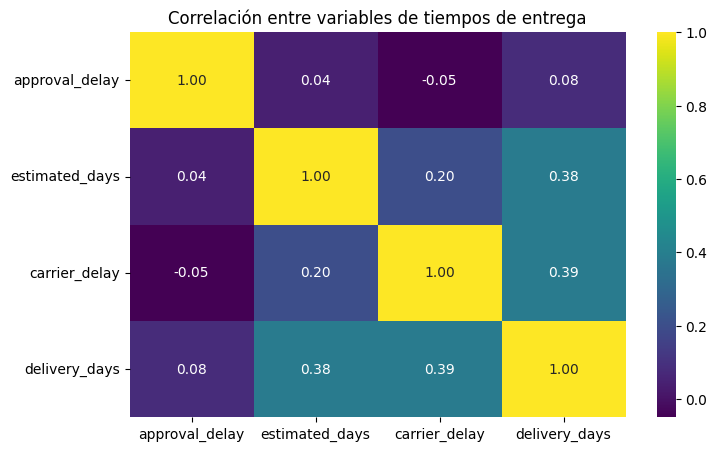

In [12]:
# Se crea un gráfico de correlaciones para ver que tan relacionadas estan las Features creadas con nuestro Target
features = ["approval_delay", "estimated_days", "carrier_delay", "delivery_days"]
corr = orders_delivered[features].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlación entre variables de tiempos de entrega")
plt.show()


In [13]:
# Se asigna en X los Features (variables independientes) y en Y el target (variable dependiente )
X = orders_delivered[["estimated_days","carrier_delay","approval_delay"]]
Y = orders_delivered["delivery_days"]


In [211]:

#Se realiza una Cross-Validación de los modelos para un entrenamiendo supervisado del tipo Regresión
modelos = {
    "LinearRegression": make_pipeline(StandardScaler(), LinearRegression()),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "K-neighborsRegression" : make_pipeline(StandardScaler(), KNeighborsRegressor())
}

# -----------------------------
# 3. Validación cruzada y métricas
# -----------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X, Y, cv=cv, scoring="neg_mean_absolute_error")
    mae_scores = -scores
    print(f"{nombre}: MAE medio={mae_scores.mean():.2f}, std={mae_scores.std():.2f}")

LinearRegression: MAE medio=5.06, std=0.03
DecisionTree: MAE medio=6.99, std=0.07
RandomForest: MAE medio=5.31, std=0.04
GradientBoosting: MAE medio=4.93, std=0.03
K-neighborsRegression: MAE medio=5.45, std=0.01


In [14]:
# Se preparan los datos de entrenamiendo y los datos de testeo.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Se asigna el mejor modelo (menor valor de MAE)
mejor_modelo = GradientBoostingRegressor(random_state= 42)
mejor_modelo.fit(X_train, y_train)

y_pred = mejor_modelo.predict(X_test)

print("\nEvaluación en test set:")
print("MAE:", mean_absolute_error(y_test, y_pred))
# Este parametro es parecido al MAE pero castiga mas a los outliers
print("RMSE:", root_mean_squared_error(y_test, y_pred))


Evaluación en test set:
MAE: 4.987834885268093
RMSE: 8.125513155957169


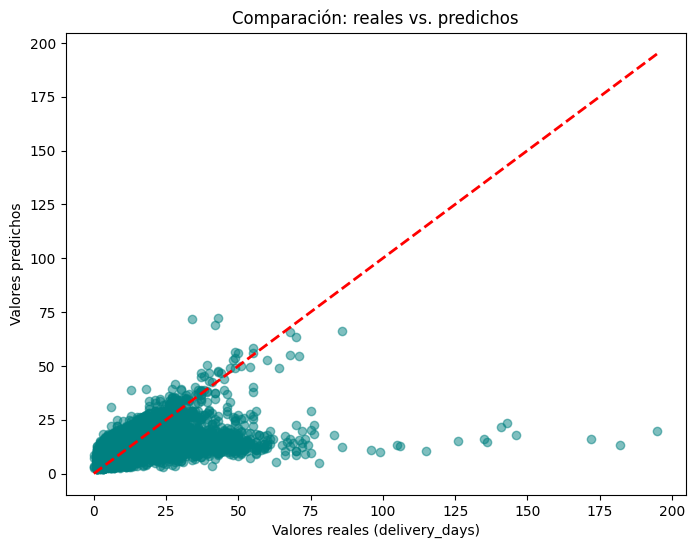

In [15]:
# Gráfico que muestra los valores predichos por el modelo 

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores reales (delivery_days)")
plt.ylabel("Valores predichos")
plt.title("Comparación: reales vs. predichos")
plt.show()


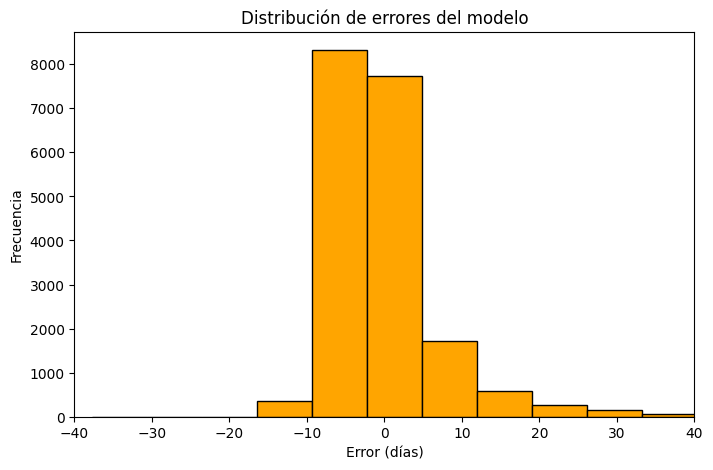

In [16]:

#Gráfico donde se visualiza la frecuencia de errores los cuales estan medidos en días
errores = y_test - y_pred

plt.figure(figsize=(8,5))
plt.hist(errores, bins=30, color="orange", edgecolor="black")
plt.xlabel("Error (días)")
plt.xlim(-40,40)
plt.ylabel("Frecuencia")
plt.title("Distribución de errores del modelo")
plt.show()

# Mismo analisis teniendo en cuenta un nuevo Feature que es el delay de shipping (ship_delay_h)

In [17]:
#Se carga un nuevo data set 
olist_orders_items = pd.read_csv("datasets/olist_order_items_dataset.csv")
olist_orders_items_copy = olist_orders_items.copy()

In [18]:
#Exploración de datos

display(olist_orders_items_copy.head())

#Informacion general
print("\nInformacion general:")
print(olist_orders_items.info())


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None


In [19]:
olist_orders_items_copy["shipping_limit_date"]  = pd.to_datetime(olist_orders_items_copy["shipping_limit_date"])

In [20]:
#Informacion general
print("\nInformacion general:")
print(olist_orders_items_copy.info())


Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
None


In [21]:
# Creamos el set de items_unique que elimina aquellos pedidos que poseen mas de un item
items_unique = olist_orders_items_copy.sort_values("shipping_limit_date").drop_duplicates("order_id")

#Estos son los pedidos entregados
print("Pedidos únicos en orders:", orders_delivered["order_id"].nunique())
#Estos pedidos unicos incluyen los que no posean estado "delivered"
print("Pedidos únicos en items_unique:", items_unique["order_id"].nunique())


Pedidos únicos en orders: 96455
Pedidos únicos en items_unique: 98666


In [22]:
# Unimos los dos datasets ["orders_delivered" y "items_unique" ] en funcion de "order_id"
orders_items_delivered = orders_delivered.merge(items_unique, on="order_id", how= "inner")

In [23]:
# Esa union nos da un set con solo los pedidos con estado "delivered(entegado)"
print(f"Cantidad de pedidos en orders_items_delivered : {orders_items_delivered.shape[0]}")

Cantidad de pedidos en orders_items_delivered : 96455


In [24]:
# Estructrura del nuevo set
orders_items_delivered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96455 entries, 0 to 96454
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96455 non-null  object        
 1   customer_id                    96455 non-null  object        
 2   order_status                   96455 non-null  object        
 3   order_purchase_timestamp       96455 non-null  datetime64[ns]
 4   order_approved_at              96455 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96455 non-null  datetime64[ns]
 6   order_delivered_customer_date  96455 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96455 non-null  datetime64[ns]
 8   delivery_days                  96455 non-null  int64         
 9   approval_delay                 96455 non-null  float64       
 10  estimated_days                 96455 non-null  int64         
 11  carrier_delay  

In [25]:
# Variable Objetivo ---> Días para la entrega
orders_items_delivered["delivery_days"] = (orders_items_delivered["order_delivered_customer_date"] - orders_items_delivered["order_purchase_timestamp"]).dt.days

# Feature : demora en aprobación (horas)
orders_items_delivered["approval_delay"] = (orders_items_delivered["order_approved_at"] - orders_items_delivered["order_purchase_timestamp"]).dt.total_seconds()/3600

#Feature : dias estimados 
orders_items_delivered["estimated_days"] = (
    orders_items_delivered["order_estimated_delivery_date"] - orders_items_delivered["order_purchase_timestamp"]
).dt.days

#Feature : tiempo hasta que es pedido fue recogido por el carrier
orders_items_delivered["carrier_delay"] = (orders_items_delivered["order_delivered_carrier_date"] - orders_items_delivered["order_approved_at"]).dt.total_seconds() / 3600

#Feature ; retraso de envio. Mide si el seller envio a tiempo o no el producto al transportista o distribuidor 
orders_items_delivered["ship_delay_h"] = (orders_items_delivered["order_delivered_carrier_date"] - orders_items_delivered["shipping_limit_date"]).dt.total_seconds()/3600


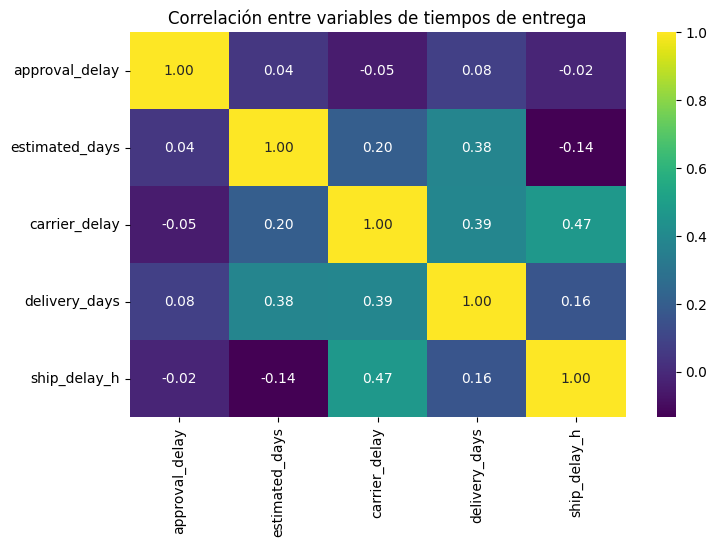

In [26]:
# Se crea un gráfico de correlaciones para ver que tan relacionadas estan las Features creadas con nuestro Target
features2 = ["approval_delay", "estimated_days", "carrier_delay", "delivery_days", "ship_delay_h"]
corr2 = orders_items_delivered[features2].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr2, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlación entre variables de tiempos de entrega")
plt.show()


In [27]:
X2 = orders_items_delivered[["estimated_days","carrier_delay","approval_delay","ship_delay_h"]]
Y2 = orders_items_delivered["delivery_days"]

In [28]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

mejor_modelo = GradientBoostingRegressor(random_state= 42)
mejor_modelo.fit(X2_train, y2_train)

y2_pred = mejor_modelo.predict(X2_test)

print("\nEvaluación en test set:")
print("MAE:", mean_absolute_error(y2_test, y2_pred))
print("RMSE:", root_mean_squared_error(y2_test, y2_pred))


Evaluación en test set:
MAE: 4.929895114840884
RMSE: 8.067920889596738


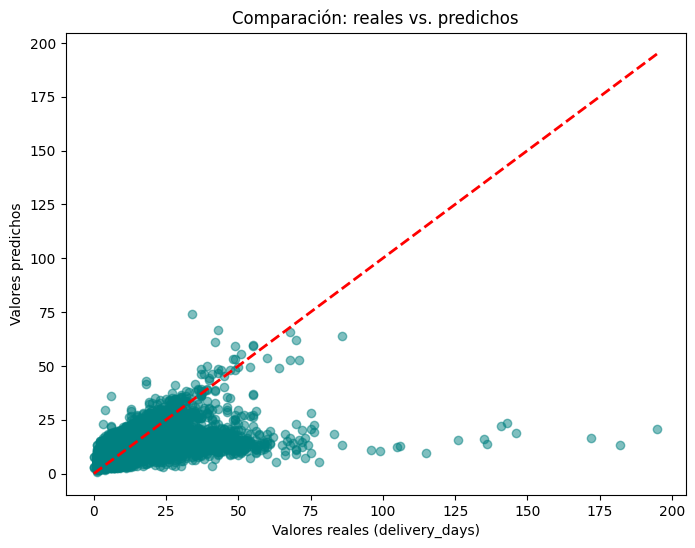

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(y2_test, y2_pred, alpha=0.5, color="teal")
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], 'r--', lw=2)
plt.xlabel("Valores reales (delivery_days)")
plt.ylabel("Valores predichos")
plt.title("Comparación: reales vs. predichos")
plt.show()

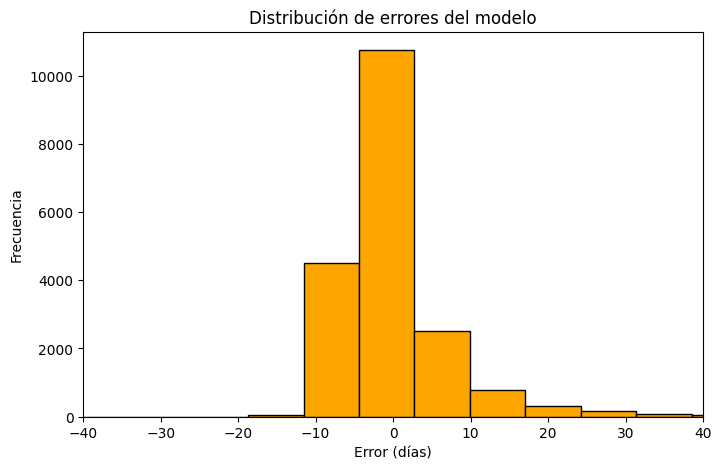

In [30]:

errores2 = y2_test - y2_pred

plt.figure(figsize=(8,5))
plt.hist(errores2, bins=30, color="orange", edgecolor="black")
plt.xlabel("Error (días)")
plt.xlim(-40,40)
plt.ylabel("Frecuencia")
plt.title("Distribución de errores del modelo")
plt.show()

# Conclusión 

- El primer modelo predice razonablemente bien para la mayoria de los pedidos entre 0 a 50 dias pero en dias mayores tiende a subestimar.

- El segundo modelo al cual se le agrega un feature mas que es "ship_delay_h" predice de manera muy parecida al primero pero se puede ver que se reduce un poco la fecuencia de los errores en comparacion al primer modelo.

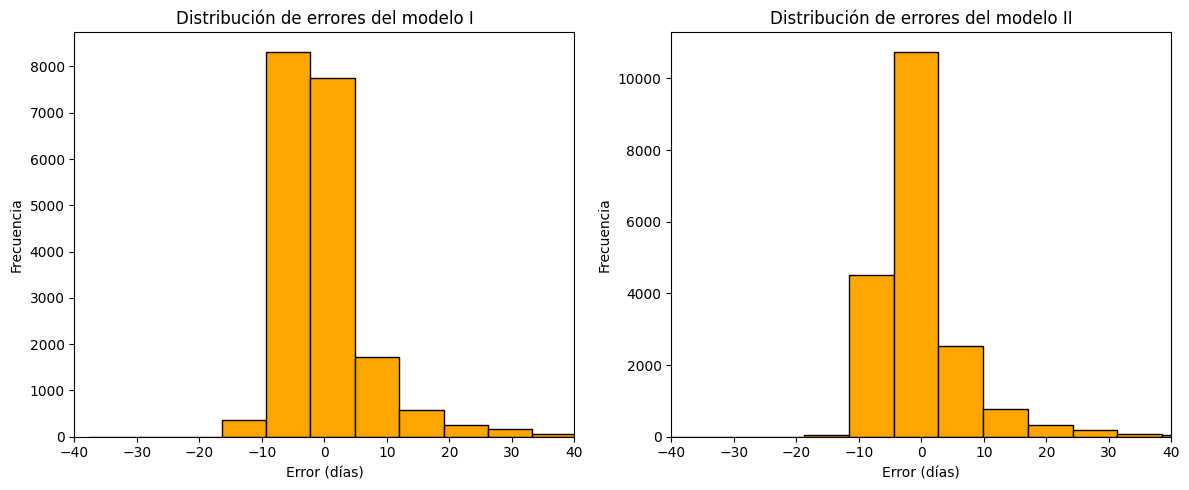

In [31]:
# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12,5))

#Primer Grafico
axes[0].hist(errores, bins=30, color="orange", edgecolor="black")
axes[0].set_xlabel("Error (días)")
axes[0].set_xlim(-40,40)
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de errores del modelo I")


#Segundo 
axes[1].hist(errores2, bins=30, color="orange", edgecolor="black")
axes[1].set_xlabel("Error (días)")
axes[1].set_xlim(-40,40)
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de errores del modelo II")


plt.tight_layout()  # ajusta espacios
plt.show()


In [33]:
# 1 = el pedido llegó tarde
# 0 = llegó en la fecha estimada o antes
orders_items_delivered["late"] = (orders_items_delivered["order_delivered_customer_date"] > orders_items_delivered["order_estimated_delivery_date"]).astype(int)


In [34]:
X3 = orders_items_delivered[["estimated_days","carrier_delay","approval_delay","ship_delay_h"]]
Y3 = orders_items_delivered["late"]

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

clf.fit(X3,Y3)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [37]:
# Predicciones de probabilidad de atraso
orders_items_delivered["p_late"] = clf.predict_proba(X3)[:,1]


In [38]:
# Flag de riesgo: 1 si probabilidad >= 0.5
orders_items_delivered["risk_flag"] = (orders_items_delivered["p_late"] >= 0.5).astype(int)


In [42]:
alertas = orders_items_delivered[orders_items_delivered["risk_flag"] == 1][["order_id","p_late","estimated_days","delivery_days"]]
print(alertas.head(20))


                            order_id    p_late  estimated_days  delivery_days
0   e481f51cbdc54678b7cc49136f2d6af7  0.539066              15              8
6   6514b8ad8028c9f2cc2374ded245783f  0.607080              21              9
8   e69bfb5eb88e0ed6a785585b27e16dbf  0.690301              24             18
12  5ff96c15d0b717ac6ad1f3d77225a350  0.534968              13              4
19  203096f03d82e0dffbc41ebc2e2bcfb7  0.958534               9             21
22  95266dbfb7e20354baba07964dac78d5  0.626880              43             18
23  f3e7c359154d965827355f39d6b1fdac  0.523158               7              4
24  fbf9ac61453ac646ce8ad9783d7d0af6  0.610493              19             28
27  91b2a010e1e45e6ba3d133fa997597be  0.702839              20             14
29  f70a0aff17df5a6cdd9a7196128bd354  0.726171              12              8
33  b276e4f8c0fb86bd82fce576f21713e0  0.512031               7              1
38  7206b86ea789983f7a273ea7fa0bc2a8  0.514045              16  

In [40]:
orders_items_delivered.head(20)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_days,approval_delay,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,ship_delay_h,late,p_late,risk_flag
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8,0.178333,...,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,-39.204167,0,0.539066,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13,30.713889,...,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,-84.890833,0,0.463197,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9,0.276111,...,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,-115.089722,0,0.332693,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13,0.298056,...,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,-30.100000,0,0.498384,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2,1.030556,...,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,-120.750833,0,0.435499,0
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,16,0.218889,...,1,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,2017-07-13 22:10:13,147.90,27.36,-55.202500,0,0.456357,0
6,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,9,0.194722,...,1,4520766ec412348b8d4caa5e8a18c464,16090f2ca825584b5a147ab24aa30c86,2017-05-22 13:22:11,59.99,15.17,-3.240278,0,0.607080,1
7,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,9,32.360556,...,1,ac1789e492dcd698c5c10b97a671243a,63b9ae557efed31d1f7687917d248a8d,2017-01-27 18:29:09,19.90,16.05,-28.210556,0,0.396351,0
8,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,18,0.175000,...,1,9a78fb9862b10749a117f7fc3c31f051,7c67e1448b00f6e969d365cea6b010ab,2017-08-11 12:05:32,149.99,19.77,-16.335556,0,0.690301,1
9,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,12,0.152222,...,1,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.00,30.53,-104.160556,0,0.405196,0


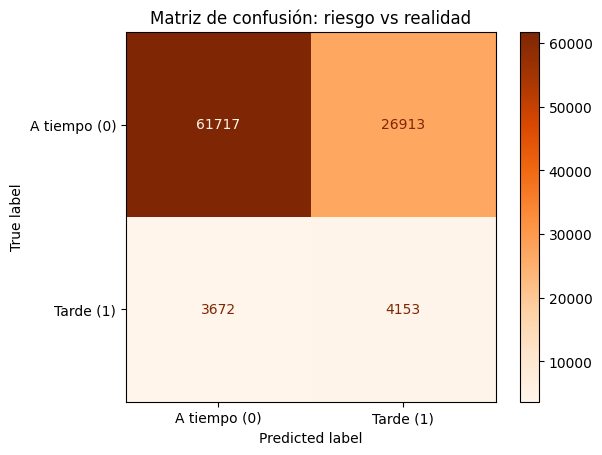

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Supongamos que:
# y_true = valores reales (columna late)
# y_pred = valores predichos (columna risk_flag)

y_true = orders_items_delivered["late"]
y_pred = orders_items_delivered["risk_flag"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A tiempo (0)", "Tarde (1)"])
disp.plot(cmap="Oranges")
plt.title("Matriz de confusión: riesgo vs realidad")
plt.show()
